In [4]:
from langchain_huggingface import HuggingFaceEmbeddings
embedings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
embedings

/official/official_docs/PythonLearning/GenerativeAIWithLangchainByKrish/projects/env/lib/python3.11/site-packages/langchain_huggingface/chat_models/__init__.py:1: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  from langchain_huggingface.chat_models.huggingface import (
/official/official_docs/PythonLearning/GenerativeAIWithLangchainByKrish/projects/env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.read

HuggingFaceEmbeddings(client=SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
), model_name='all-MiniLM-L6-v2', cache_folder=None, model_kwargs={}, encode_kwargs={}, multi_process=False, show_progress=False)

In [165]:
from langchain.vectorstores.cassandra import Cassandra
astra_vector_store =Cassandra(embedding=embedings,table_name="qna_demo",session=None,keyspace=None)

In [ ]:
from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from langchain.indexes.vectorstore import VectorStoreIndexWrapper
from app.config import Config
from app.lib.vectorestore import VectorStore

# create vectore store        
vectore_store = VectorStore(
    connection=Config.PG_CONNECTION,
    collection_name=Config.PG_COLLECTION_NAME,
    embeddings=HuggingFaceEmbeddings(model_name='all-MiniLM-L6-v2')
)

# document_retriver_tool = vectore_store.get_retriver_tool()


pg_vector_index = VectorStoreIndexWrapper(vectorstore=vectore_store.vectorestore)

In [13]:
# retriever = astra_vector_store.as_retriever()
retriever = vectore_store.vectorestore.as_retriever()
res = retriever.invoke("What is Impact of Covid19")
res
# res = document_retriver_tool.invoke("What is impact of COVID19 on college students?")
# res

[Document(id='545c9960-5e81-4112-b2d4-7eb8832d16dc', metadata={'page': 14, 'title': '', 'author': '', 'source': '/official/official_docs/PythonLearning/GenerativeAIWithLangchainByKrish/projects/PersonalAssitantBot/data/w27392.pdf', 'creator': 'LaTeX with hyperref', 'moddate': '2020-06-18T14:23:52-04:00', 'subject': '', 'trapped': '/False', 'keywords': '', 'producer': 'pdfTeX-1.40.20', 'page_label': '15', 'total_pages': 26, 'creationdate': '2020-06-18T07:30:06+00:00', 'ptex.fullbanner': 'This is pdfTeX, Version 3.14159265-2.6-1.40.20 (TeX Live 2019) kpathsea version 6.3.1'}, page_content='and health impacts of COVID-19 have been signiﬁcantly more pronounced for less advantaged groups, and\nthat these are partially responsible for the underlying heterogeneity in the impacts that we document. Our\nresults suggest that by focusing on addressing the economic and health burden imposed by COVID-19, as\nmeasured by a relatively narrow set of mitigating factors, policy makers may be able to pre

In [14]:
res[1].page_content

"The Impact of COVID-19 on Student Experiences and Expectations: Evidence from a Survey\nEsteban M. Aucejo, Jacob F. French, Maria Paola Ugalde Araya, and Basit Zafar\nNBER Working Paper No. 27392\nJune 2020\nJEL No. I2,I23,I24\nABSTRACT\nIn order to understand the impact of the COVID-19 pandemic on higher education, we surveyed \napproximately 1,500 students at one of the largest public institutions in the United States using an \ninstrument designed to recover the causal impact of the pandemic on students' current and \nexpected outcomes. Results show large negative effects across many dimensions. Due to \nCOVID-19: 13% of students have delayed graduation,  40% lost a job, internship, or a job offer, \nand 29% expect to earn less at age 35. Moreover, these effects have been highly heterogeneous. \nOne quarter of students increased their study time by more than 4\n hours per week due to \nCOVID-19, while another quarter decreased their study time by more than 5 hours per week. This"

## Langgraph Application


In [27]:
from typing import Literal
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel,Field

# Data model
class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""

    datasource: Literal["vectorstore", "web_search","chat_history"] = Field(
        ...,
        description="Given a user question choose to route it to vectorstore ,internet or chat_history.",
    )


In [29]:
from langchain_groq import ChatGroq
llm = ChatGroq(model="Gemma2-9b-it")
structured_llm_router = llm.with_structured_output(RouteQuery)

# Prompt
system = """You are an expert at routing a user question to a vectorstore or wikipedia.
The vectorstore contains documents related to agents, prompt engineering, and adversarial attacks.
Use the vectorstore for questions on these topics. Otherwise, use wiki-search."""
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

question_router = route_prompt | structured_llm_router
print(
    question_router.invoke(
        {"question": "What is an Agent?"}
    )
)
print(question_router.invoke({"question": "who is Rahul Gandhi?"}))
print(question_router.invoke({"question": "What was my last chat?"}))

datasource='vectorstore'
datasource='web_search'
datasource='chat_history'


In [30]:
# ### Working With Tools
# from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper
# from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun

# ## Arxiv and wikipedia Tools
# arxiv_wrapper=ArxivAPIWrapper(top_k_results=1, doc_content_chars_max=200)
# arxiv=ArxivQueryRun(api_wrapper=arxiv_wrapper)

# api_wrapper=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=200)
# wiki=WikipediaQueryRun(api_wrapper=api_wrapper)
# wiki.run("Who is Narendra Modi?")

In [37]:
## Graph

from typing import List

from typing_extensions import TypedDict


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    question: str
    generation: str
    documents: List[str]

In [32]:
from langchain.schema import Document


def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]
    print(question)

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}

In [33]:
from langchain.schema import Document
from langchain_community.tools import TavilySearchResults

search_tool = TavilySearchResults(k=6)

def web_search(state):
    """
    web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---wikipedia---")
    print("---HELLO--")
    question = state["question"]
    print(question)

    # web search
    docs = search_tool.invoke({"query": question})
    #print(docs["summary"])
    search_results = docs
    web_results = Document(page_content=search_results)

    return {"documents": web_results, "question": question}

In [34]:
### Edges ###


def route_question(state):
    """
    Route question to web search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})
    print('----'+source.datasource+"--------------------")
    if source.datasource == "web_search":
        print("---ROUTE QUESTION TO Web SEARCH---")
        return "web_search"
    elif source.datasource == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"

In [35]:
### Edges ###


def route_question(state):
    """
    Route question to wiki search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})
    print(f"--------------------------------{source.datasource}++++++++++++++++")
    if source.datasource == "web_search":
        print("---ROUTE QUESTION TO Wiki SEARCH---")
        return "web_search"
    elif source.datasource == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"

In [38]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)
# Define the nodes
workflow.add_node("web_search", web_search)  # web search
workflow.add_node("retrieve", retrieve)  # retrieve

# Build graph
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "web_search": "web_search",
        "vectorstore": "retrieve",
    },
)
workflow.add_edge( "retrieve", END)
workflow.add_edge( "web_search", END)
# Compile
app = workflow.compile()

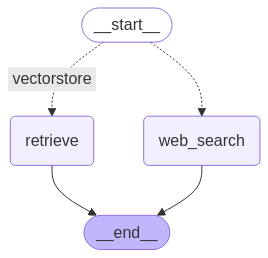

In [39]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [41]:
from pprint import pprint

# Run
inputs = {
    "question": "What is Impact of COVID19 to college students search from Documents?"
}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value['documents'][0].dict()['metadata']['description'])

---ROUTE QUESTION---
--------------------------------vectorstore++++++++++++++++
---ROUTE QUESTION TO RAG---
---RETRIEVE---
What is Impact of COVID19 to college students search from Documents?
"Node 'retrieve':"
'\n---\n'


/tmp/ipykernel_67970/171099121.py:16: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  pprint(value['documents'][0].dict()['metadata']['description'])


KeyError: 'description'

In [200]:
from pprint import pprint

# Run
inputs = {
    "question": "What is Python"
}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value['documents'])

---ROUTE QUESTION---
--------------------------------wiki_search++++++++++++++++
---ROUTE QUESTION TO Wiki SEARCH---
---wikipedia---
---HELLO--
What is Python
"Node 'wiki_search':"
'\n---\n'
Document(page_content='Page: Python (programming language)\nSummary: Python is a high-level, general-purpose programming language. Its design philosophy emphasizes code readability with the use of significant indentation.\nPy')
